In [12]:
from neuralprophet import NeuralProphet, set_random_seed, load
from model_xgb import ModelXGB
from model_np import ModelNP
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse

Evaluation models' performance using PJM metered loads in Oct. 2022.

## NeuralProphet

In [18]:
hrl = pd.read_csv('Data/hrl_load_metered_oct.csv')
hrl['ds'] = pd.to_datetime(hrl['datetime_beginning_ept'])
hrl = hrl.groupby(['ds', 'zone']).agg({'mw': 'sum'}).reset_index()
zmap = pd.read_csv('Data/zone_mapping_hist_peak.csv')
hrl = hrl[hrl['zone'].isin(zmap['zone'])]
hrl.tail()

,ds,zone,mw
20058,2022-10-31 23:00:00,PEP,2443.662
20059,2022-10-31 23:00:00,PL,3739.562
20060,2022-10-31 23:00:00,PN,1635.920
20061,2022-10-31 23:00:00,PS,4088.193
20062,2022-10-31 23:00:00,RECO,123.348


In [ ]:
zone = 'CE'
hrl1 = hrl[hrl['zone'] == zone]

m1 = ModelNP(zone)
pred1 = []
for i in range(31):
    idx1 = 24*i
    idx2 = idx1 + 24*7
    p1 = m1.predict(hrl1.iloc[idx1:idx2])
    p1 = p1[p1['source'] == 'pred']
    pred1.append(p1)
pred1 = pd.concat(pred1, axis=0)

<AxesSubplot: title={'center': 'MAPE: 0.0383, RMSE: 454.8034'}, xlabel='ds'>

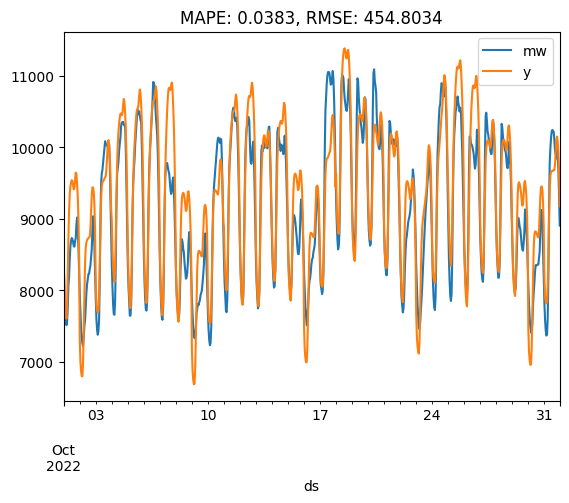

In [25]:
pred_m1 = pred1.merge(hrl1, on='ds')
e1 = mape(pred_m1['y'], pred_m1['mw'])
e2 = mse(pred_m1['y'], pred_m1['mw'], squared=False)
pred_m1.plot(x='ds', y=['mw', 'y'], title="MAPE: {}, RMSE: {}".format(round(e1, 4), round(e2, 4)))

## XGBoost

In [21]:
m2 = ModelXGB(zone)

start_date = datetime(2022, 10, 1)
pred2 = []
for dt in range(31):
    p2 = m2.predict(start_date.strftime('%Y-%m-%d'))
    pred2.append(p2)
    start_date = start_date + timedelta(1)

pred2 = pd.concat(pred2, axis=0)

<AxesSubplot: title={'center': 'MAPE: 0.0442, RMSE: 723.2868'}, xlabel='ds'>

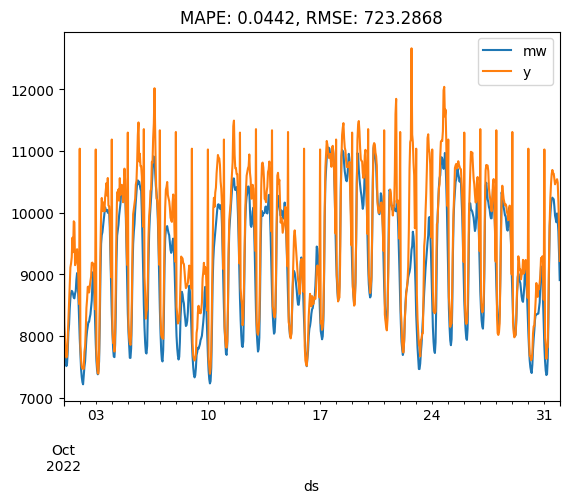

In [23]:
hrl1 = hrl[hrl['zone'] == zone]
pred2['ds'] = pd.to_datetime(pred2['date']) + pred2['hour'].astype('timedelta64[h]')
pred_m2 = pred2.merge(hrl1, on='ds')
pred_m2 = pred_m2.rename(columns={'mw_x': 'y', 'mw_y': 'mw'})
e1 = mape(pred_m2['y'], pred_m2['mw'])
e2 = mse(pred_m2['y'], pred_m2['mw'], squared=False)
pred_m2.plot(x='ds', y=['mw', 'y'], title="MAPE: {}, RMSE: {}".format(round(e1, 4), round(e2, 4)))